Ceny godzinowe z: https://www.pse.pl/dane-systemowe/funkcjonowanie-rb/raporty-dobowe-z-funkcjonowania-rb/podstawowe-wskazniki-cenowe-i-kosztowe/rynkowa-cena-energii-elektrycznej-rce    

```bash
wget https://www.pse.pl/getcsv/-/export/csv/PL_CENY_RYN_EN/data_od/20220401/data_do/20220431 -O 2023.04.csv
```


In [1]:
%matplotlib inline
import pandas as pd

def load_ceny_df(filename):
    df = pd.read_csv(filename, sep=';')
    df['RCE'] = df['RCE'].str.replace('�','')
    df['RCE'] = df['RCE'].str.replace(',','.')
    df['RCE'] = df['RCE'].astype(float)
    df['Data'] = pd.to_datetime(df['Data'], format='%Y%m%d')
    df['Godzina'] = df['Godzina'].astype('int32')
    df['Godzina'] = df['Godzina'].mod(24)
    return df
    
def load_oddane_df(filename):
    oddane = pd.read_csv(filename, sep=';')
    oddane['Data i godzina']
    oddane['Data i godzina'] = pd.to_datetime(oddane['Data i godzina'], format='%Y-%m-%d %H:%M')
    oddane['Wartosc[kWh/kvar]'] = oddane['Wartosc[kWh/kvar]'].str.replace(',','.')
    oddane['Wartosc[kWh/kvar]'] = oddane['Wartosc[kWh/kvar]'].astype(float)
    oddane['Oddane kWh'] = oddane['Wartosc[kWh/kvar]']
    return oddane


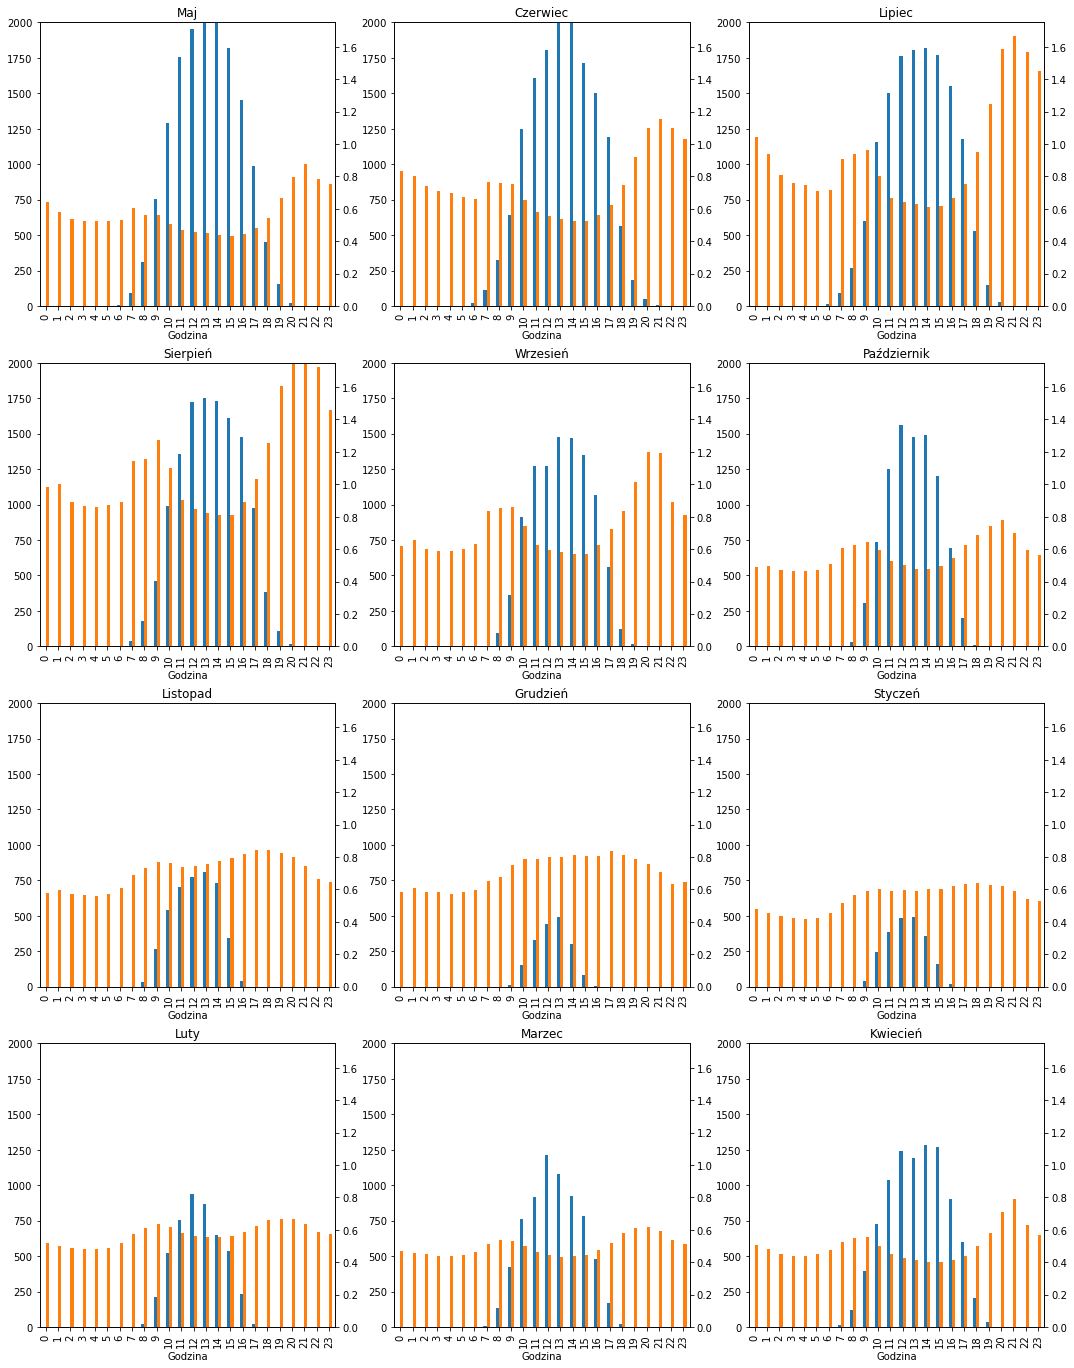

In [2]:
import matplotlib.pyplot as plt

def ceny_godzinowo(filename):
    cena = load_ceny_df(filename)
    ceny_godzinowo = cena.groupby(cena['Godzina']).agg({'RCE': 'mean'})
    return ceny_godzinowo


def oddane_godzinowo(filename):
    oddane = load_oddane_df(filename)
    oddane_godzinowo = oddane.groupby(oddane['Data i godzina'].dt.hour).agg({'Oddane kWh': 'mean'})
    return oddane_godzinowo

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(18, 24))
oddane_pliki=['oddane_2022_05.csv','oddane_2022_06.csv','oddane_2022_07.csv','oddane_2022_08.csv','oddane_2022_09.csv','oddane_2022_10.csv','oddane_2022_11.csv','oddane_2022_12.csv','oddane_2023_01.csv','oddane_2023_02.csv','oddane_2023_03.csv','oddane_2023_04.csv']
ceny_pliki=['2022.05.csv','2022.06.csv','2022.07.csv','2022.08.csv','2022.09.csv','2022.10.csv','2022.11.csv','2022.12.csv','2023.01.csv','2023.02.csv','2023.03.csv','2023.04.csv']
miesiace=['Maj','Czerwiec','Lipiec','Sierpień','Wrzesień','Październik','Listopad','Grudzień','Styczeń','Luty','Marzec','Kwiecień']

#polaczone.plot(kind='bar', secondary_y='Oddane kWh')

for i,mies in enumerate(miesiace):
    oddane = oddane_godzinowo(oddane_pliki[i])
    ceny = ceny_godzinowo(ceny_pliki[i])
    polaczone = oddane.join(ceny)
    polaczone.index = polaczone.index.rename('Godzina')
    polaczone.plot(kind='bar', secondary_y='Oddane kWh', ax=fig.axes[i])
    fig.axes[i].set_ylim([0,2000])
    fig.axes[i].right_ax.set_ylim(0,1.75)
    fig.axes[i].set_title(miesiace[i])
    fig.axes[i].legend().remove()

## Ceny godzinowe energii i ilość energii oddawanej przez moją fotowoltaikę do sieci w okresie od V 2022 do IV 2023.
Kolorem pomarańczowym oznaczone są ceny godzinowe prądu w zł/mWh (skala po lewej stronie), a kolorem niebieskim prąd oddany do sieci w kWh (skala po prawej stronie). Na osi x znajdują się kolejne godziny. Wykresy przedstawiają uśrednione wartości dla godzin (cykl dobowy) wyliczone oddzielnie dla kolejnych miesięcy.

Ilość oddawanej energii jest ewidentnie skorelowana z nasłonecznieniem. Jest duża w miesiącach wiosennych i letnich, a spada w jesiennych i zimowych, równocześnie w cyklu dobowym największe wartości są w godzinach południowych i wczesnym popołudniem. Dla większości miesięcy (wyjątkiem są grudzień i styczeń) jest to niestety negatywnie skorelowane z cenami godzinowymi energii. Oznacza to, że rozpoczęcie stosowania cen godzinowych w netbillingu sprawi, że cena za oddawaną energię będzie niska wtedy kiedy fotowoltaika produkuje jej najwięcej, a wysoka wtedy kiedy jej nie produkuje. Widoczne na wykresach uśrednienie po godzinach pokazuje jednak, że różnice w cenach nie są dramatyczne. Niskie ceny prądo to około 500 zł za mWh, a wysokie (w miesiącach wakacyjnych ceny zarówno w dołku jak i na górce są generalnie wyższe i jest dodatkowa górka późnym wieczorem - godziny 20 i 21, kiedy prądu już fotowoltaika nie produkuje) to okolice 750 zł za mWh. Relacja 500 do 750 nie wygląda tragicznie, ale nieo mniej atrakcyjnie niż 80% funkcjonujące w starym sytemie.

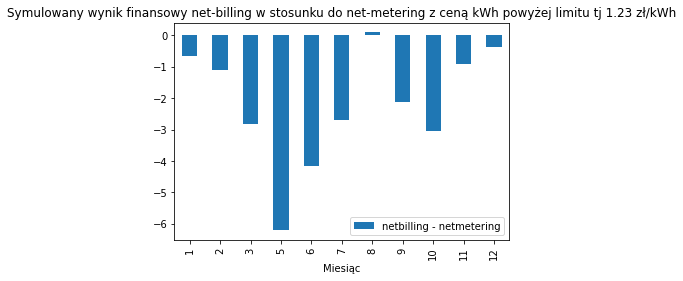

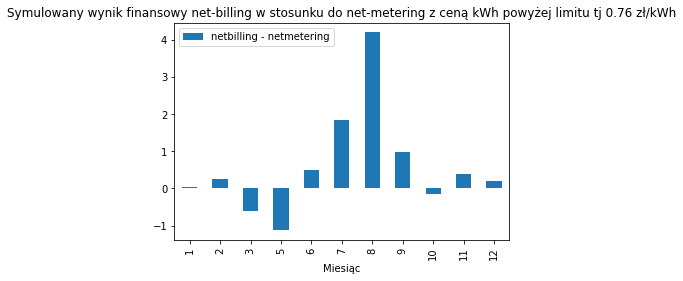

In [55]:
# ceny z 1 kWh
cena_do_limitu = 0.76
do_limitu_80 = cena_do_limitu * 0.8
cena_powyzej_limitu = 1.23
powyzej_limitu_80 = cena_powyzej_limitu * 0.8

df = pd.DataFrame()
for plik in ceny_pliki:
    df = pd.concat([df, load_ceny_df(plik)], axis=0)    
df['delta'] = pd.to_timedelta(df['Godzina'],'h')
df['Data i godzina'] = df['delta'] + df['Data']

oddane = pd.DataFrame()
for plik in oddane_pliki:
    oddane = pd.concat([oddane, load_oddane_df(plik)], axis=0)

def wykres_porowania(odniesienie, tekstowo):
    polaczone = df.merge(oddane, left_on='Data i godzina', right_on='Data i godzina')
    polaczone['Wartość godzinowa'] = polaczone['Oddane kWh'] * polaczone['RCE'] / 1000
    polaczone['Wartość 80%'] = polaczone['Oddane kWh'] * odniesienie
    wartosc_oddana = polaczone['Oddane kWh'].sum() * cena_powyzej_limitu
    polaczone['netbilling - netmetering'] = polaczone['Wartość godzinowa'] - polaczone['Wartość 80%']
    polaczone['netbilling - netmetering'] = 100 * polaczone['netbilling - netmetering']/wartosc_oddana

    polaczone.groupby(polaczone['Data i godzina'].dt.month).agg({'netbilling - netmetering': sum}).plot(kind='bar')
    plt.title(f'Symulowany wynik finansowy net-billing w stosunku do net-metering z ceną kWh powyżej limitu tj {tekstowo} zł/kWh')
    plt.xlabel('Miesiąc')

    
wykres_porowania(powyzej_limitu_80, cena_powyzej_limitu)
wykres_porowania(do_limitu_80, cena_do_limitu)


Wynik porównanie netbilingu opartego o ceny godzinowe z netmeteringiem zależy od doboru punktu odniesienia. Jeżeli przyjąć cenę kWh narzuconą przez rząd dla zużycia prądu do limitu netbilling daje nawet lepsze wyniki niż dotychczasowy system. Jeżeli jako punkt odniesienia przyjąć 80% z ceny rynkowej (czyli obowiązującej po przekroczeniu limitu) to wynik jest o wiele mniej zachęcający.